## Setup Environment
***

In [1]:
%matplotlib widget

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import lightning as L

from tqdm import tqdm
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor

In [2]:
from utils.models import Network
from utils.data import generate_dataset, format_dataset
from utils.plots import show_dataset, plot_training, plot_comparisons

## Create Experiment Parameters
***

In [3]:
params = {}

# Create: Experiment Objective
# - experiment: (0) Many to 1, (1) many to many

params["experiment"] = 0

# Create: System Experiemnts
# - accelerator: gpu type, (MacOS-M, NVIDIA) gpu, (N/A) cpu
# - strategy: type of distributed computation environment
# - num_devices: number of gpus available
# - num_workers: number of cpus for dataloader

params["system"] = {"accelerator": "gpu", 
                    "strategy": "auto", 
                    "num_devices": 1,
                    "num_workers": 8}

# Create: Path Parameters
# - results: path to store performance analytics
# - version: version number of experiment to investigate for results

params["paths"] = {"results": "results",
                   "version": 0}

# Create: Data Parameters
# - num_sequence: sequence size for network observations
# - num_features: number of dataset features 
# - num_samples: number of dataset observations
# - amplitude: min and max range for signal height
# - frequency: min and max range for signal repitition

params["data"] = {"num_sequence": 3,
                  "num_samples": 2000,
                  "num_features": 100,
                  "amplitude": {"min": 1, "max": 10},
                  "frequency": {"min": 1, "max": 10}}

# Create: Model Parameters
# - batch_size: number of observations per sample to network
# - num_layers: number of stacked lstm cells
# - hidden_layers: number of lstm features
# - learning_rate: how much to listen to gradient
# - num_epochs: number of times model observes full dataset 

params["model"] = {"batch_size": 64,
                   "num_layers": 3,
                   "hidden_size": 512,
                   "learning_rate": 3e-3,
                   "num_epochs": 100,}

# Create: Evaluation Parameters
# - tags: column names from saved algorithm training analytics

params["evaluation"] = {"tags": ["train_error_epoch", 
                                 "valid_error_epoch", 
                                 "lr-Adam"]}

## Create Dataset
***

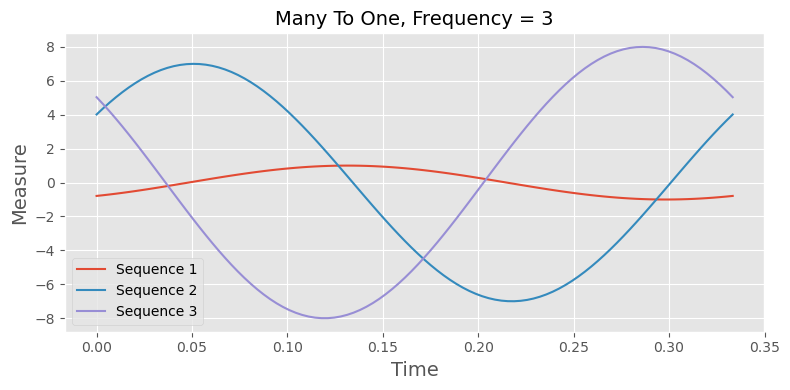

In [4]:
dataset = generate_dataset(params)
show_dataset(params, dataset)

In [5]:
train, valid = format_dataset(params, dataset)

## Train LSTM
***

In [6]:
# Create: Model

model = Network(params)

In [7]:
task = params["experiment"]
path_results = params["paths"]["results"]

num_epochs = params["model"]["num_epochs"]

strategy = params["system"]["strategy"]
accelerator = params["system"]["accelerator"]
num_devices = params["system"]["num_devices"]

# Create: Logger

path_save = path_results + "/exp_%s" % task
exp_logger = CSVLogger(save_dir=path_save)

# Create: Trainer

lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(callbacks=[lr_monitor], 
                    logger=exp_logger, devices=num_devices, 
                    log_every_n_steps=1, max_epochs=num_epochs, 
                    strategy=strategy, accelerator=accelerator)

# Train: Model

trainer.fit(model=model, train_dataloaders=train, val_dataloaders=valid)

MisconfigurationException: No supported gpu backend found!

## Evaluate LSTM
***

In [9]:
def get_latest_version(path):
    """
    Purpose:
    - Gather most recent version folder
    
    Arguments:
    - path (str): path to version folders
    """

    all_folders = [int(ele.replace("version_", "")) for ele in os.listdir(path)]

    return all_folders[np.argmax(all_folders)]

def get_training_results(path, target_names):
    """
    Purpose:
    - Gather and show training analytics
    
    Arguments:
    - path (str): path to analytics file
    - target_names (list[str]): columns of analytics file to display
    """

    # Gather: All Analytics
    
    print("Loading path: %s" % path)

    data = pd.read_csv(path)

    # Display: Target Analytics
    
    for name in target_names:
    
        df = data.dropna(subset=[name])
        
        if "lr" in name:
            tag = "epoch"
            x_vals = list(range(df.shape[0]))
        else:
            tag = name.split("_")[-1]
            x_vals = df[tag]
        
        y_vals = df[name]
    
        title = "Plotting %s vs %s" % (name, tag)
        y_label = "%s" % name
        x_label = "%s" % tag
    
        plot_training(x_vals, y_vals, title, x_label, y_label)

Loading path: results/exp_0/lightning_logs/version_2/metrics.csv


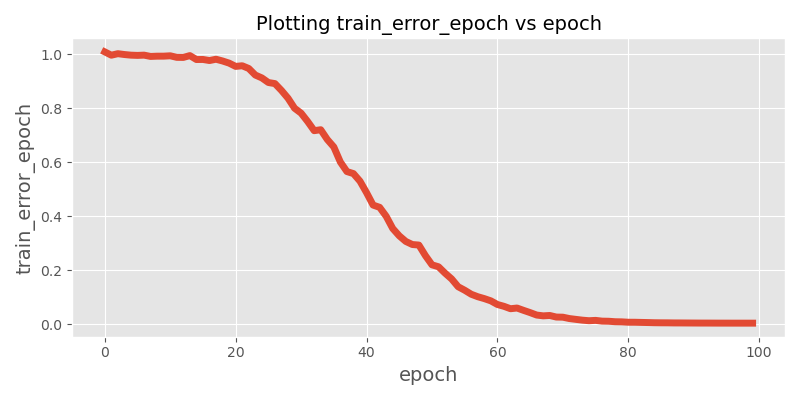

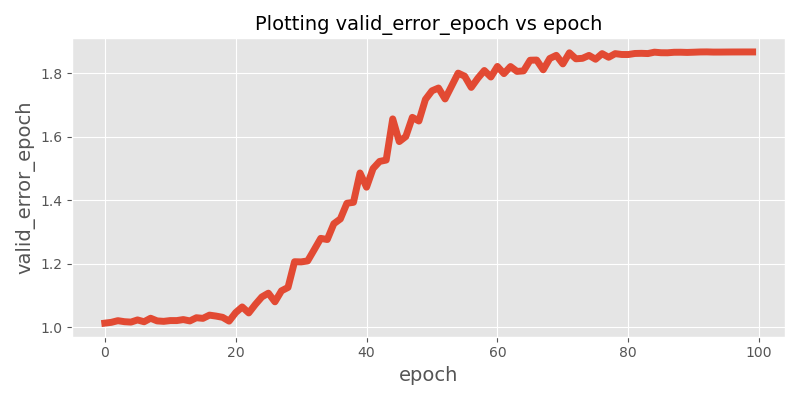

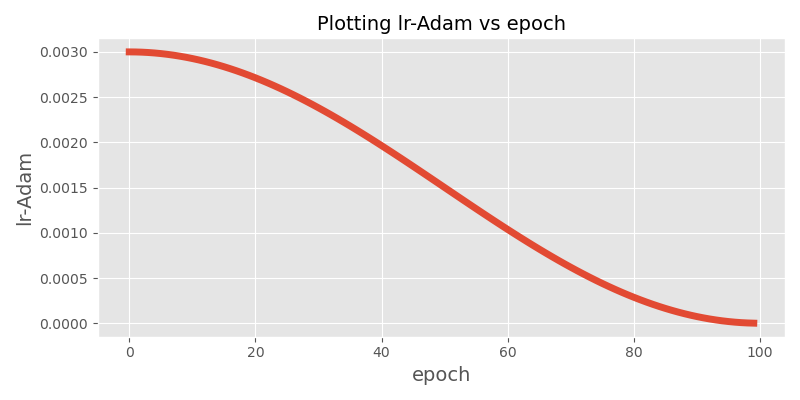

In [10]:
target_names = params["evaluation"]["tags"]

# Gather: Most Recent Trained Model (Highest Version)

path_version = os.path.join(path_save, "lightning_logs")
version = get_latest_version(path_version)

# Update: Paths

path_file = os.path.join(path_version, "version_%s" % version, "metrics.csv")

# Visualize: Training Analytics

get_training_results(path_file, target_names)

In [11]:
def get_comparisons(model, data, task):
    """
    Purpose:
    - Compare trained model predictions with ground truth
    
    Arguments:
    - model (Network): trained model
    - data (torch.utils.data.DataLoader): pytorch dataset
    - task (int): experiment objective flag
    """

    # Gather: Model Predictions & Ground Truths
    
    all_preds, all_labels = [], []
    for samples, labels in tqdm(data, desc="Evaluating"):

        with torch.no_grad():

            if task == 0:
                preds = model(samples).detach().cpu()
            else:
                target_seq = labels.size()[1]
                preds = model(samples, target_seq)
        
        all_preds.append(preds)
        all_labels.append(labels)

    # Format: Predictions & Ground Truths
    
    all_preds = torch.vstack(all_preds)
    all_labels = torch.vstack(all_labels)

    # Calculate: Similarity 
    
    measures = torch.sqrt(torch.abs(all_preds - all_labels) ** 2).numpy()
    measures =  1 / (1 + measures)

    # Display: Analytics 

    plot_comparisons(measures)

Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


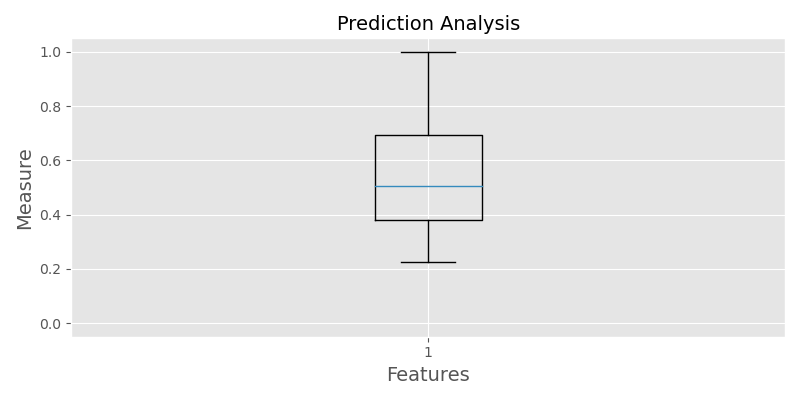

In [12]:
# Re-generate: DataLoaders

train, valid = format_dataset(params, dataset)

# Calculate: Comparison Analytics

get_comparisons(model, valid, task)